In [ ]:
import tensorflow

In [ ]:
import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

import matplotlib.pyplot as plt

from keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from keras.layers import Flatten,MaxPooling2D,Dropout

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model, load_model

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

print("Tensorflow-version:", tensorflow.__version__)

import cv2
from google.colab.patches import cv2_imshow

from google.colab import drive
drive.mount("/content/drive/")

Tensorflow-version: 2.8.0
Mounted at /content/drive/


In [ ]:
%tensorflow_version 2.0
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.0`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
Found GPU at: /device:GPU:0


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.835387566999998
GPU (s):
0.05095893499998283
GPU speedup over CPU: 75x


# **Accessing the Dataset**

In [ ]:
os.getcwd()
os.chdir("/content/drive/My Drive/Food-11 image dataset/")
target_labels = ["Bread", 
                 "Dairy product", 
                 "Dessert", 
                 "Egg", 
                 "Fried food", 
                 "Meat", 
                 "Noodles-Pasta", 
                 "Rice", 
                 "Seafood", 
                 "Soup", 
                 "Vegetable-Fruit"]
path = "/content/drive/My Drive/Food-11 image dataset/"

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.applications import vgg16 

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [ ]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function=vgg16.preprocess_input
        )

validate_datagen = ImageDataGenerator( 
    preprocessing_function = vgg16.preprocess_input
                                      )

test_datagen = ImageDataGenerator(
    preprocessing_function= vgg16.preprocess_input
    )

In [ ]:
BATCH_SIZE=64

In [ ]:
train_generator = train_datagen.flow_from_directory(path+"training",
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes= target_labels,
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validate_generator = validate_datagen.flow_from_directory(path+"validation",
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes= target_labels,
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

test_generator = test_datagen.flow_from_directory(path+"evaluation",
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes= target_labels,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             seed=42)

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


# **VGG-16**

In [ ]:
from tensorflow.keras.applications import VGG16
from keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from keras.layers import Flatten,MaxPooling2D,Dropout
from keras.models import Model

In [ ]:
basemodel= VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)
    )

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
basemodel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
for layer in basemodel.layers:
	layer.trainable = False

In [ ]:
x=basemodel.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(11,activation='softmax')(x) #FC-layer

In [ ]:
model=Model(inputs=basemodel.input,outputs=preds)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# **Compile the Model**

In [ ]:
from tensorflow.keras.optimizers import Adam

opt =  tensorflow.keras.optimizers.Adam(learning_rate=.01)
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath = "/content/drive/My Drive/Food-11 image dataset/MODEL_VGG-16-{epoch:02d}-{val_accuracy:.2f}.hdf5"
# the ModelCheckpoint mentioned here will save the model after an epoch if the "val-accuracy" has increased. 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
from keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(
    monitor = 'val_accuracy', 
    min_delta = 0.01,
    patience = 10,
    restore_best_weights = True,
)

In [ ]:
vgg16_history = model.fit(
    train_generator, 
    batch_size=BATCH_SIZE,
    steps_per_epoch = train_generator.n//train_generator.batch_size, 
    epochs = 15,  
    validation_data = validate_generator,
    validation_steps = validate_generator.n // validate_generator.batch_size,
    callbacks = [checkpoint, earlystopping],
    verbose=1
)

Epoch 1/15
154/154 [==============================] - ETA: 0s - loss: 1.3625 - accuracy: 0.5917 
Epoch 1: val_accuracy improved from -inf to 0.71963, saving model to /content/drive/My Drive/Food-11 image dataset/MODEL_VGG-16-01-0.72.hdf5
154/154 [==============================] - 3563s 23s/step - loss: 1.3625 - accuracy: 0.5917 - val_loss: 0.9665 - val_accuracy: 0.7196
Epoch 2/15
154/154 [==============================] - ETA: 0s - loss: 0.9775 - accuracy: 0.6751
Epoch 2: val_accuracy improved from 0.71963 to 0.79068, saving model to /content/drive/My Drive/Food-11 image dataset/MODEL_VGG-16-02-0.79.hdf5
154/154 [==============================] - 259s 2s/step - loss: 0.9775 - accuracy: 0.6751 - val_loss: 0.6641 - val_accuracy: 0.7907
Epoch 3/15
154/154 [==============================] - ETA: 0s - loss: 0.8813 - accuracy: 0.7077
Epoch 3: val_accuracy did not improve from 0.79068
154/154 [==============================] - 262s 2s/step - loss: 0.8813 - accuracy: 0.7077 - val_loss: 0.8713 

In [ ]:
# converting the epochs history to data frame and saving in drive
vgg16_history_frame = pd.DataFrame(vgg16_history.history)

In [ ]:
vgg16_history_frame.to_csv("vgg16_history.csv")
!cp vgg16_history.csv path

In [ ]:
vgg16_history_frame = pd.read_csv("vgg16_history.csv")
vgg16_history_frame.index  = np.arange(1,16) 
vgg16_history_frame.head(2)

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
1,0,1.362457,0.591716,0.966463,0.719634
2,1,0.977542,0.675066,0.664124,0.790684


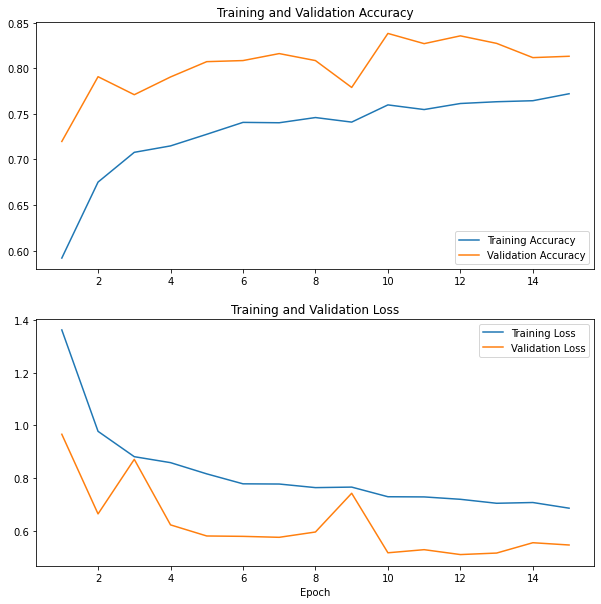

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(vgg16_history_frame['accuracy'], label='Training Accuracy')
plt.plot(vgg16_history_frame['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(vgg16_history_frame['loss'], label='Training Loss')
plt.plot(vgg16_history_frame['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

# **Fine-Tuning**

In [ ]:
basemodel.trainable = True

In [ ]:
for idx,layer in enumerate(basemodel.layers):
  print(idx,layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7f0cb1258590> True
1 <keras.layers.convolutional.Conv2D object at 0x7f0cb123f390> True
2 <keras.layers.convolutional.Conv2D object at 0x7f0cb19cb910> True
3 <keras.layers.pooling.MaxPooling2D object at 0x7f0bcaa19110> True
4 <keras.layers.convolutional.Conv2D object at 0x7f0bcaa06750> True
5 <keras.layers.convolutional.Conv2D object at 0x7f0bcd1f3c90> True
6 <keras.layers.pooling.MaxPooling2D object at 0x7f0bcd180110> True
7 <keras.layers.convolutional.Conv2D object at 0x7f0bcd188810> True
8 <keras.layers.convolutional.Conv2D object at 0x7f0bcd0c30d0> True
9 <keras.layers.convolutional.Conv2D object at 0x7f0bcd0ba290> True
10 <keras.layers.pooling.MaxPooling2D object at 0x7f0bcd0cb3d0> True
11 <keras.layers.convolutional.Conv2D object at 0x7f0bcd0cfd50> True
12 <keras.layers.convolutional.Conv2D object at 0x7f0cb19cb390> True
13 <keras.layers.convolutional.Conv2D object at 0x7f0bcd0ba310> True
14 <keras.layers.pooling.MaxPooling2D obje

In [ ]:
for layer in basemodel.layers[:-15]:
    layer.trainable=False

for layer in basemodel.layers[-15:]:
  layer.trainable = True

Define Learning Rate

In [ ]:
def step_decay(epoch):
    initial_lr = 1e-2 
    
    if epoch < 9: 
        return initial_lr
    else: 
        return 0.00008

In [ ]:
import matplotlib.pyplot as plt                        
%matplotlib inline  

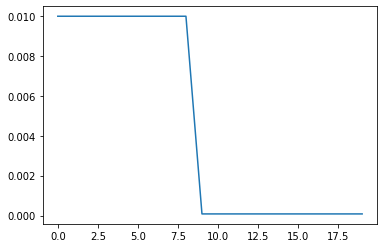

In [ ]:
x = [i for i in range(20)]
y = [step_decay(i) for i in range(20)]
plt.plot(x, y)

In [ ]:
# from tensorflow.keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras.metrics import top_k_categorical_accuracy
import math

# add LearningRateScheduler to update it
lr_scheduler = LearningRateScheduler(step_decay)

# calculate top_5_accuracy to evalute the model 
def top_5_accuracy(y_true, y_pred): 
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

In [ ]:
from tensorflow.keras.optimizers import Adam

opt =  tensorflow.keras.optimizers.Adam(learning_rate=.0001)

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [ ]:
from keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(
    monitor = 'val_accuracy', 
    min_delta = 0.01,
    patience = 10,
    restore_best_weights = True,
)

In [ ]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
model_file=('/content/drive/My Drive/Food-11 image dataset/MODEL_VGG-16_FT-{epoch:02d}-{val_accuracy:.2f}.hdf5')

checkpoint_ft = ModelCheckpoint(filepath=model_file, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list_ft = [checkpoint_ft]

In [ ]:
# fine tune the already trained model
vgg16_ft_history = model.fit(
    train_generator, 
    batch_size=64,
    steps_per_epoch = train_generator.n//train_generator.batch_size, 
    epochs = 15,  
    validation_data = validate_generator,
    validation_steps = validate_generator.n // validate_generator.batch_size,
    callbacks = [checkpoint_ft, earlystopping, anne],
    verbose=1
)

Epoch 1/15
154/154 [==============================] - ETA: 0s - loss: 0.8204 - accuracy: 0.7354
Epoch 1: val_accuracy improved from -inf to 0.68308, saving model to /content/drive/My Drive/Food-11 image dataset/MODEL_VGG-16_FT-01-0.68.hdf5
154/154 [==============================] - 321s 2s/step - loss: 0.8204 - accuracy: 0.7354 - val_loss: 1.0837 - val_accuracy: 0.6831 - lr: 1.0000e-04
Epoch 2/15
154/154 [==============================] - ETA: 0s - loss: 0.6098 - accuracy: 0.8009
Epoch 2: val_accuracy improved from 0.68308 to 0.82754, saving model to /content/drive/My Drive/Food-11 image dataset/MODEL_VGG-16_FT-02-0.83.hdf5
154/154 [==============================] - 307s 2s/step - loss: 0.6098 - accuracy: 0.8009 - val_loss: 0.5598 - val_accuracy: 0.8275 - lr: 1.0000e-04
Epoch 3/15
154/154 [==============================] - ETA: 0s - loss: 0.5360 - accuracy: 0.8310
Epoch 3: val_accuracy did not improve from 0.82754
154/154 [==============================] - 306s 2s/step - loss: 0.5360 -

In [ ]:
vgg16_ft_history_frame = pd.DataFrame(vgg16_ft_history.history)

In [ ]:
vgg16_ft_history_frame.to_csv("vgg16_ft_history_frame.csv")
!cp vgg16_ft_history_frame.to_csv("vgg16ft_history_frame.csv")


/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `cp vgg16_ft_history_frame.to_csv("vgg16ft_history_frame.csv")'


In [ ]:
vgg16ft_history_frame = pd.read_csv("vgg16_ft_history_frame.csv")
vgg16_ft_history_frame.index = np.arange(1,16)
vgg16_ft_history_frame.head(2)

,loss,accuracy,val_loss,val_accuracy,lr
1,0.820365,0.735360,1.083675,0.683078,0.0001
2,0.609784,0.800857,0.559824,0.827535,0.0001


In [ ]:
vgg16_full_history = pd.concat([vgg16_ft_history_frame], axis=0)

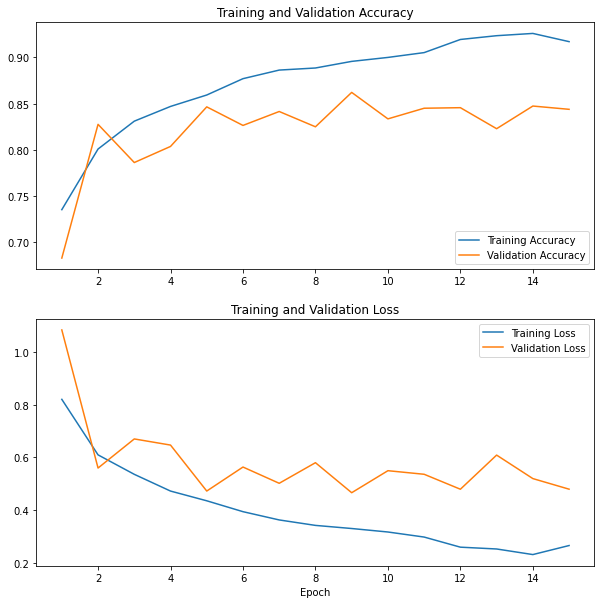

In [ ]:
acc = vgg16_full_history["accuracy"]
val_acc = vgg16_full_history['val_accuracy']

loss = vgg16_full_history['loss']
val_loss = vgg16_full_history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

# **Evaluation of Model  using Test Generator**

In [ ]:
# a function to evaluate the prediction of dataset from a given model
def model_evaluation(model, generator):
  generator.reset() # There is a reset() method for the datagenerators which resets it to the first batch. So whenever you would want to correlate the model output with the filenames you need to set shuffle as False and reset the datagenerator before performing any prediction. This will ensure that our files are being read properly and there is nothing wrong with them.

  true_classes = generator.classes
  class_indices = dict((v,k) for k,v in generator.class_indices.items())
  preds = model.predict(generator)
  preds_classes = np.argmax(preds, axis=1)
  return [true_classes, preds_classes, generator.class_indices.keys()]

In [ ]:
# for the prediction made, this function prints a confusion matrix 
def plot_confusion_matrix(true_classes, preds_classes, target_names):
  cm = confusion_matrix(true_classes, preds_classes)

  df_cm = pd.DataFrame(cm, columns=target_names, index = target_names)
  plt.figure(figsize=(12,12))
  sns.set(font_scale=1.4) # for label size
  sns.heatmap(df_cm, annot=True, fmt='g', cbar=False, cmap="rocket_r") # font size , annot_kws={"size": 16}
  plt.title('Confusion Matrix\n', y=1.1)
  plt.ylabel('Actual Label\n')
  plt.xlabel('Predicted Label\n')

  plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
result = model_evaluation(model, test_generator)
true_classes, preds_classes, target_names = result[0], result[1], result[2]
test_ft_acc=accuracy_score(true_classes, preds_classes) 
print("Vgg-16 WITH Fine-Tuning on Testing Set has Accuracy: {:.2f}%".format(test_ft_acc * 100))

Vgg-16 WITH Fine-Tuning on Testing Set has Accuracy: 87.00%


In [ ]:
print(classification_report(true_classes, preds_classes,target_names =  target_names))

                 precision    recall  f1-score   support

          Bread       0.88      0.72      0.79       368
  Dairy product       0.86      0.74      0.79       148
        Dessert       0.77      0.90      0.83       500
            Egg       0.89      0.90      0.89       335
     Fried food       0.98      0.69      0.81       287
           Meat       0.73      0.96      0.83       432
  Noodles-Pasta       0.97      0.98      0.98       147
           Rice       0.99      0.90      0.94        96
        Seafood       0.93      0.89      0.91       303
           Soup       0.99      0.90      0.94       500
Vegetable-Fruit       0.94      0.98      0.96       231

       accuracy                           0.87      3347
      macro avg       0.90      0.87      0.88      3347
   weighted avg       0.88      0.87      0.87      3347



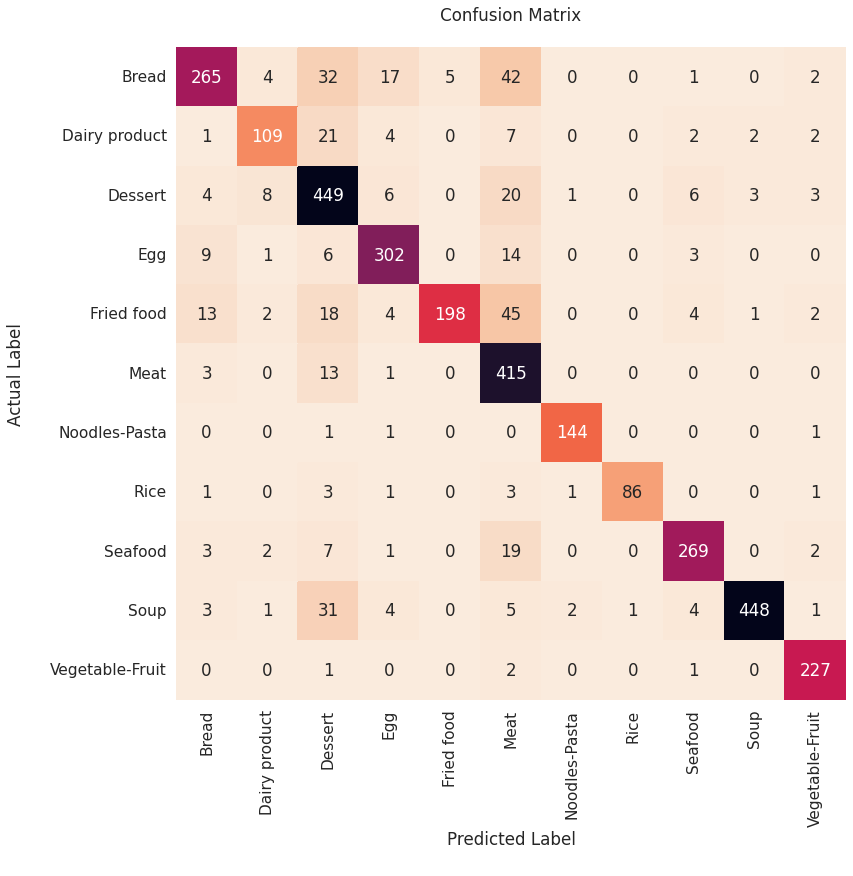

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
plot_confusion_matrix(true_classes, preds_classes, target_names)